# Analyzing multiple datasets and producing summary statistics with

Pandas

Lino Galiana  
2024-09-23

<div class="alert alert-info" role="alert">
<h3 class="alert-heading">Version 🇫🇷</h3>
This is the French version 🇫🇷 of that chapter,to see the English version go <a href="https://pythonds.linogaliana.fr/content/manipulation/02_pandas_suite.html">there</a>
</div>

# 1. Introduction

The [introductory chapter to `Pandas`](../../content/manipulation/02_pandas_intro.qmd) presented the concept of data organized in the form of a *DataFrame* and the practicality of the `Pandas` ecosystem for performing simple operations on a dataset.

It is rare to work exclusively on a raw source. A dataset generally gains value when compared to other sources. For researchers, this allows contextualizing the information present in one source by comparing or associating it with other sources. For data scientists in the private sector, it often involves linking information about the same person in multiple customer databases or comparing customers with each other.

One of the benefits of modern data science tools, especially `Pandas`, is the ease with which they allow restructuring sources to work on multiple datasets in a project. This chapter consolidates the principles previously seen by refining the data processing. It will mainly explore two types of operations:

-   Group descriptive statistics;
-   Data merging by common characteristics.

Performing this work simply, reliably, and efficiently is essential for data scientists as this task is common. Fortunately, `Pandas` handles this very well with structured data. In the following chapters, and also throughout the [section on text data processing](../../content/nlp/index.qmd), we will see how to handle less structured data.

Through this work, we will deepen our understanding of a real world phenomenon through detailed descriptive statistics. This is an essential step before moving on to [inferential statistics](https://en.wikipedia.org/wiki/Statistical_inference), the approach that consists of formalizing and generalizing correlations or causal relationships between observed characteristics and a phenomenon.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Skills at the end of this chapter</h3>

-   Retrieve an official dataset from Insee;
-   Build group descriptive statistics and switch between data levels;
-   Merge data (*reshape*, *merge*) to add value;
-   Create a beautiful table to communicate descriptive statistics.

</div>

## 1.1 Environment

The previous chapter used almost exclusively the `Pandas` library. In this chapter, we will use other packages in addition to it.

As explained below, we will use a library called `pynsee` to retrieve Insee data useful for enriching our Ademe dataset. This library is not installed by default in `Python`. Before using it, it is necessary to install it, along with the `great_tables` library that we will see at the end of this chapter:

In [1]:
!pip install xlrd
!pip install pynsee
!pip install great_tables

The instruction `!pip install <pkg>` is a way to tell `Jupyter`, the execution engine behind notebooks, that the following command (`pip install <pkg>`) is a system command to be executed outside of `Python` (in the terminal, for example, for a `Linux` system).

The essential packages to start this chapter are as follows:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynsee
import pynsee.download


To obtain reproducible results, you can set the seed of the pseudo-random number generator.

In [3]:
np.random.seed(123)


## 1.2 Data used

This tutorial continues the exploration of the dataset from the previous chapter:

-   Greenhouse gas emissions estimated at the municipal level by ADEME. The dataset is available on [data.gouv](https://www.data.gouv.fr/fr/datasets/inventaire-de-gaz-a-effet-de-serre-territorialise/#_) and can be directly queried in Python with [this URL](https://koumoul.com/s/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert);

The issues of data enrichment (associating one source with another based on common characteristics) will be presented using two sources produced by Insee:

-   The [official geographic code](https://www.insee.fr/fr/statistiques/fichier/6800675/v_commune_2023.csv), a reference produced by Insee used to identify municipalities with a unique code, unlike the postal code;
-   The [*Filosofi*](https://www.insee.fr/fr/metadonnees/source/serie/s1172) data, a source on French income at a fine spatial scale constructed by Insee from tax returns and social benefit information. In this case, we will use income levels and populations[1] at the municipal level to compare them with our emissions data.

To facilitate the import of Insee data, it is recommended to use the [`pynsee`](https://pynsee.readthedocs.io/en/latest/) package, which simplifies access to the main Insee datasets available on the [insee.fr](https://www.insee.fr/fr/accueil) website or via APIs.

<div class="alert alert-info" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-comment"></i> Note</h3>

The `pynsee` package has two main entry points:

-   The Insee APIs, which will be illustrated in the dedicated chapter.
-   Some datasets directly from the Insee website ([insee.fr](https://www.insee.fr/fr/accueil))

In this chapter, we will exclusively use the second approach through the `pynsee.download` module.

The list of available data from this package is [here](https://inseefrlab.github.io/DoReMIFaSol/articles/donnees_dispo.html). The `download_file` function expects a unique identifier to know which database to fetch and restructure from the [insee.fr](https://www.insee.fr/fr/accueil) website.

<details>

<summary>

Knowing the list of available databases

</summary>

To know the list of available databases, you can use the `meta = pynsee.get_file_list()` function after importing `pynsee`. This returns a `DataFrame` in which you can search, for example, using a keyword search:

``` python
import pynsee

meta = pynsee.get_file_list()
meta.loc[meta["label"].str.contains(r"Filosofi.*2016")]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|     | id                   | name            | label                                             | collection | link                                              | type | zip  | big_zip | data_file                 | tab    | ... | label_col | date_ref   | meta_file | separator | type_col | long_col | val_col | encoding | last_row | missing_value |
|-----|----------------------|-----------------|---------------------------------------------------|------------|---------------------------------------------------|------|------|---------|---------------------------|--------|-----|-----------|------------|-----------|-----------|----------|----------|---------|----------|----------|---------------|
| 79  | FILOSOFI_COM_2016    | FILOSOFI_COM    | Données Filosofi niveau communal – 2016           | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | COM    | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 80  | FILOSOFI_EPCI_2016   | FILOSOFI_EPCI   | Données Filosofi niveau EPCI – 2016               | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | EPCI   | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 81  | FILOSOFI_ARR_2016    | FILOSOFI_ARR    | Données Filosofi niveau arondissement – 2016      | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | ARR    | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 82  | FILOSOFI_DEP_2016    | FILOSOFI_DEP    | Données Filosofi niveau départemental – 2016      | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | DEP    | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 83  | FILOSOFI_REG_2016    | FILOSOFI_REG    | Données Filosofi niveau régional – 2016           | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | REG    | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 84  | FILOSOFI_METRO_2016  | FILOSOFI_METRO  | Données Filosofi niveau France métropolitaine ... | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | METRO  | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 85  | FILOSOFI_AU2010_2016 | FILOSOFI_AU2010 | Données Filosofi niveau aire urbaine – 2016       | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | AU2010 | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 86  | FILOSOFI_UU2010_2016 | FILOSOFI_UU2010 | Données Filosofi niveau unité urbaine – 2016      | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | UU2010 | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |
| 87  | FILOSOFI_ZE2010_2016 | FILOSOFI_ZE2010 | Données Filosofi niveau zone d’emploi – 2016      | FILOSOFI   | https://www.insee.fr/fr/statistiques/fichier/4... | xls  | True | False   | base-cc-filosofi-2016.xls | ZE2010 | ... | NaN       | 2016-01-01 | NaN       | NaN       | NaN      | NaN      | NaN     | NaN      | NaN      | NaN           |

<p>9 rows × 24 columns</p>
</div>

Here, meta\[‘label’\].str.contains(r”Filosofi.*2016”) means: “pandas find me all labels containing the terms Filosofi and 2016.” (.* means “no matter the number of words or characters in between”).

</details>

</div>

# 2. Retrieving data for this chapter

## 2.1 French carbon emissions dataset

As explained in the previous chapter, these data can be imported very simply with `Pandas`:

[1] Ideally, it would be more coherent, for demographic data, to use the [legal populations](https://www.insee.fr/fr/information/2008354), from the census. However, this base is not yet natively integrated into the `pynsee` library that we will use in this chapter. An open exercise is proposed to construct population aggregates from anonymized individual census data (the [detailed files](https://www.insee.fr/fr/information/2383306)).

In [6]:
import pandas as pd

url = "https://koumoul.com/s/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert"
emissions = pd.read_csv(url)
emissions.head(2)


We will already keep the names of the emitting sectors present in the database to simplify subsequent uses:

In [7]:
secteurs = emissions.select_dtypes(include="number").columns


Subsequent exploitations of these data will use the departmental dimension, the construction of which we demonstrated in the previous chapter:

In [8]:
emissions["dep"] = emissions["INSEE commune"].str[:2]


We will use the Filosofi data (income data) at the municipal level for 2016. It is not the same year as the CO2 emissions data, so it is not perfectly rigorous, but it will still illustrate the main functionalities of `Pandas`.

The main entry point for the `pynsee` function is the `download_file` function.

The code to download the data is as follows:

In [9]:
from pynsee.download import download_file

filosofi = download_file("FILOSOFI_COM_2016")


The resulting `DataFrame` looks like this:

In [11]:
filosofi.sample(3)


3 rows × 29 columns

`Pandas` automatically handled the variable types. It does this relatively well, but a check is always useful for variables that have a specific status.

For variables that are not of type `float` but should be, we modify their type.

In [12]:
filosofi = filosofi.astype({c: "float" for c in filosofi.columns[2:]})


A quick glance at the data gives a fairly precise idea of how the data are organized. We notice that some variables in `filosofi` seem to have many missing values (statistical secrecy), while others seem complete. If we want to exploit `filosofi`, we need to pay attention to the chosen variable.

Our ultimate goal will be to link the information contained between these two datasets. Otherwise, we risk being frustrated: we will want to know more about carbon emissions but will be very limited in the possibilities of analysis without adding additional information from `filosofi`.

# 3. Descriptive statistics by group

## 3.1 Principle

In the previous chapter, we saw how to obtain an aggregated statistic easily with `Pandas`. However, it is common to have data with intermediate analysis strata that are relevant: geographical variables, membership in socio-demographic groups related to recorded characteristics, temporal period indicators, etc. To better understand the structure of the data, data scientists are often led to construct descriptive statistics on sub-groups present in the data. For example, we previously constructed emission statistics at the national level. But what about the emission profiles of different departments? To answer this question, it will be useful to aggregate our data at the departmental level. This will give us different information from the initial dataset (municipal level) and the most aggregated level (national level).

In `SQL`, it is very simple to segment data to perform operations on coherent blocks and recollect results in the appropriate dimension. The underlying logic is that of *split-apply-combine*, which is adopted by data manipulation languages, including `pandas` [which is no exception](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html).

The following image, from [this site](https://unlhcc.github.io/r-novice-gapminder/16-plyr/), well represents how the `split`-`apply`-`combine` approach works:

<figure>
<img src="https://unlhcc.github.io/r-novice-gapminder/fig/12-plyr-fig1.png" alt="Split-apply-combine (Source: unlhcc.github.io)" />
<figcaption aria-hidden="true">Split-apply-combine (Source: <a href="https://unlhcc.github.io/r-novice-gapminder/16-plyr/">unlhcc.github.io</a>)</figcaption>
</figure>

In `Pandas`, we use `groupby` to segment the data according to one or more axes (this [tutorial](https://realpython.com/pandas-groupby/) on the subject is particularly useful). All the aggregation operations (counting, averages, etc.) that we saw earlier can be applied by group.

Technically, this operation involves creating an association between labels (values of group variables) and observations. Using the `groupby` method does not trigger operations until a statistic is implemented; it simply creates a formal relationship between observations and groupings that will be used later:

In [13]:
filosofi["dep"] = filosofi["CODGEO"].str[:2]
filosofi.groupby("dep").__class__


pandas.core.groupby.generic.DataFrameGroupBy

As long as we do not call an action on a `DataFrame` by group, such as `head` or `display`, `pandas` performs no operations. This is called *lazy evaluation*. For example, the result of `df.groupby('dep')` is a transformation that has not yet been evaluated:

In [14]:
filosofi.groupby("dep")


## 3.2 Illustration 1: counting by group

To illustrate the application of this principle to counting, we can count the number of municipalities by department in 2023 (this statistic changes every year due to municipal mergers). For this, we simply take the reference of French municipalities from the official geographical code (COG) and count by department using `count`:

In [15]:
import requests
from io import StringIO
import pandas as pd

url_cog_2023 = "https://www.insee.fr/fr/statistiques/fichier/6800675/v_commune_2023.csv"
url_backup = "https://minio.lab.sspcloud.fr/lgaliana/data/python-ENSAE/cog_2023.csv"

# Try-except clause to avoid timout issue sometimes
# Without timeout problem, pd.read_csv(url_cog_2023) would be sufficient
try:
    response = requests.get(url_cog_2023)
    response.raise_for_status()
    cog_2023 = pd.read_csv(StringIO(response.text))
except requests.exceptions.Timeout:
    print("Failing back to backup")
    cog_2023 = pd.read_csv(url_backup)


With this dataset, without resorting to group statistics, we can already know how many municipalities, departments, and regions we have in France, respectively:

In [17]:
communes = cog_2023.loc[cog_2023["TYPECOM"] == "COM"]
communes.loc[:, ["COM", "DEP", "REG"]].nunique()

COM    34945
DEP      101
REG       18
dtype: int64

Now, let’s look at the departments with the most municipalities. It is the same counting function where we play, this time, on the group from which the statistic is calculated.

Calculating this statistic is quite straightforward when you understand the principle of calculating statistics with `Pandas`:

In [18]:
communes = cog_2023.loc[cog_2023["TYPECOM"] == "COM"]
communes.groupby("DEP").agg({"COM": "nunique"})

101 rows × 1 columns

In SQL, we would use the following query:

``` sql
SELECT dep, COUNT DISTINCT "COM" AS COM 
FROM communes
GROUP BY dep 
WHERE TYPECOM == 'COM';
```

The output is an indexed `Series`. This is not very convenient as we mentioned in the previous chapter. It is more practical to transform this object into a `DataFrame` with `reset_index`. Finally, with `sort_values`, we obtain the desired statistic:

In [19]:
(
    communes.groupby("DEP")
    .agg({"COM": "nunique"})
    .reset_index()
    .sort_values("COM", ascending=False)
)


101 rows × 2 columns

## 3.3 Illustration 2: aggregates by group

To illustrate aggregates by group, we can use the Insee `filosofi` dataset and count the population using the variable `NBPERSMENFISC16`.

To calculate the total for the whole of France, we can do it in two ways:

In [20]:
filosofi["NBPERSMENFISC16"].sum() * 1e-6


66.9322415

In [21]:
filosofi.agg({"NBPERSMENFISC16": "sum"}).div(1e6)


NBPERSMENFISC16    66.932242
dtype: float64

where the results are reported in millions of people. The logic is the same when doing group statistics, it’s just a matter of replacing `filosofi` with `filosofi.groupby('dep')` to create a partitioned version of our dataset by department:

In [23]:
filosofi.groupby("dep")["NBPERSMENFISC16"].sum()

dep
01     613088.0
02     514249.0
03     329435.0
04     156537.5
05     133992.5
        ...    
92    1583682.0
93    1586664.5
94    1345977.0
95    1226059.0
97    1191947.0
Name: NBPERSMENFISC16, Length: 97, dtype: float64

In [24]:
filosofi.groupby("dep").agg({"NBPERSMENFISC16": "sum"})


97 rows × 1 columns

The second approach is more practical because it directly gives a `Pandas` `DataFrame` and not an unnamed indexed series. From this, a few basic manipulations can suffice to have a shareable table on departmental demographics. However, this table would be somewhat rudimentary as we currently only have the department numbers. To get the names of the departments, we would need to use a second dataset and merge the common information between them (in this case, the department number). This is the subject of the next part.

## 3.4 Exercice d’application

This application exercise uses the `Ademe` dataset named `emissions` previously discussed.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 1: Group Aggregations</h3>

1.  Calculate the total emissions of the “Residential” sector by department and compare the value to the most polluting department in this sector. Draw insights from the reality that this statistic reflects.

2.  Calculate the total emissions for each sector in each department. For each department, calculate the proportion of total emissions coming from each sector.

<details>

<summary>

Hint for this question

</summary>

-   *“Group by”* = `groupby`
-   *“Total emissions”* = `agg({*** : "sum"})`

</details>

</div>

In question 1, the result should be as follows:

This ranking may reflect demographics rather than the process we wish to measure. Without the addition of information on the population of each département to control for this factor, it is difficult to know whether there is a structural difference in behavior between the inhabitants of Nord (département 59) and Moselle (département 57).

At the end of question 2, let’s take the share of emissions from agriculture and the tertiary sector in departmental emissions:

5 rows × 21 columns

5 rows × 21 columns

These results are quite logical; rural departments have a larger share of their emissions from agriculture, while urban departments have higher emissions from the tertiary sector, which is related to the higher density of these areas.

With these statistics, we progress in understanding our dataset and, consequently, the nature of CO2 emissions in France. Descriptive statistics by group help us better grasp the spatial heterogeneity of our phenomenon.

However, we remain limited in our ability to interpret the obtained statistics without using additional information. To give meaning and value to a statistic, it is generally necessary to associate it with additional knowledge; otherwise, it remains detached.

In the rest of this chapter, we will consider a primary approach which is the merging of complementary data. This process is called data enrichment. These data can be observations at the same level as the original source. For example, one of the most common merges is associating a customer database with a purchase database to relate purchasing behavior to characteristics that may explain it. Data merges can also occur at different conceptual levels, generally at a more aggregated level to contextualize finer data and compare an observation to measures within a similar group. For instance, we can associate individual travel times and modes with those of the same age group or people living in the same municipality to compare the differences between certain individuals and a similar sociodemographic group.

# 4. Restructuring datasets

## 4.1 Principle

When we have multiple pieces of information for the same individual or group, we generally find two types of data structures:

-   **Wide** format: the data contains repeated observations for the same individual (or group) in different columns.
-   **Long** format: the data contains repeated observations for the same individual in different rows, with a column distinguishing the observation levels.

An example of the distinction between the two can be taken from Hadley Wickham’s reference book, [*R for Data Science*](https://r4ds.hadley.nz/):

<figure>
<img src="https://d33wubrfki0l68.cloudfront.net/3aea19108d39606bbe49981acda07696c0c7fcd8/2de65/images/tidy-9.png" alt="Wide and Long Data Formats (Source: R for Data Science)" />
<figcaption aria-hidden="true">Wide and Long Data Formats (Source: <a href="https://r4ds.hadley.nz/"><em>R for Data Science</em></a>)</figcaption>
</figure>

The following cheat sheet will help remember the functions to apply if needed:

![](https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/reshape.png)

Switching from a *wide* format to a *long* format (or vice versa) can be extremely practical because certain functions are more suitable for one form of data than the other.

Generally, with `Python` as with `R`, **long formats are often preferable**. Wide formats are rather designed for spreadsheets like `Excel`, where we have a limited number of rows to create pivot tables from.

## 4.2 Application

The ADEME data, and the Insee data as well, are in the *wide* format. The next exercise illustrates the benefit of converting from *long* to *wide* before creating a plot with the `plot` method seen in the previous chapter.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 2: Restructuring Data: Wide to Long</h3>

1.  Create a copy of the ADEME data by doing `df_wide = emissions.copy()`

2.  Restructure the data into the *long* format to have emission data by sector while keeping the commune as the level of analysis (pay attention to other identifying variables).

3.  Sum the emissions by sector and represent it graphically.

4.  For each department, identify the most polluting sector.

</div>

# 5. Joining data

## 5.1 Principle

Here we will focus on the most favorable case, which is the situation where information allows for an exact match between two databases\[^fuzzy\]. It is a daily necessity for data scientists to merge information present in multiple files. For example, in business databases, customer information (address, age, etc.) will be in one file, sales in another, and product characteristics in a third file. To have a complete base that compares all this information, it will be necessary to join these three files based on common information.

This practice stems from the fact that many information systems take the form of a star schema:

<figure>
<img src="https://www.databricks.com/wp-content/uploads/2022/04/star-schema-erd.png" alt="Illustration of the star schema (Source: Databricks)" />
<figcaption aria-hidden="true">Illustration of the star schema (Source: <a href="https://www.databricks.com/wp-content/uploads/2022/04/star-schema-erd.png">Databricks</a>)</figcaption>
</figure>

This structuring of information is closely related to the model of relational tables from the 1980s. Today, there are more flexible data models where information is stacked in a data lake without an a priori structure. Nevertheless, this star schema model retains relevance because it allows sharing information only with those who need it, leaving it to those who need to link data to do so.

Since the logic of the star schema historically comes from relational databases, it is natural that it is an approach intrinsically linked to the philosophy of SQL, even in the vocabulary. The term “data join” is often used, inherited from the SQL `JOIN` term, and the way to describe joins (left join, right join…) comes directly from the associated SQL instructions.

We generally speak of left and right bases to illustrate the joins:

<figure>
<img src="https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/join_initial.png" alt="Joins" />
<figcaption aria-hidden="true">Joins</figcaption>
</figure>

## 5.2 Implementation with `Pandas`

In `Pandas`, the most practical method to join datasets based on common characteristics is `merge`. Its main arguments allow for controlling the join behavior. We will explore them visually.

In our case, for constructing statistics on carbon emissions, the left base will be the `emissions` DataFrame, and the right base will be the `filosofi` DataFrame:

In [33]:
emissions.head(2)


In [34]:
filosofi.head(2)


2 rows × 30 columns

We refer to join keys as the variable(s) necessary for merging data. These are the variables common to both datasets. They do not need to have the same name, but they must share common values; otherwise, the intersection between these two datasets is the empty set.

We can manipulate two dimensions in the join (this will be clearer later with graphical examples):

-   There are mainly three types of merges: left join, right join, or a combination of the two, depending on the type of pivot we want to implement.
-   Then, there are two ways to merge the values once we have chosen a pivot: inner or outer join. In the first case, we only keep the observations where the join keys are present in both datasets; in the second, we keep all observations of the pivot key variables, even if the second dataset does not have such observations, resulting in missing values.

In the examples below, we will use the commune codes and departments as join keys. Using the department is not necessary since it is directly deduced from the commune code, but it helps illustrate the principle of joins on multiple variables. Note that the name of the commune is intentionally set aside for joins, even though it is common information to both datasets. However, as it is a textual field, which may follow different formatting norms in the two datasets, it is not reliable for an exact join.

To illustrate the principle of the left or right pivot, we will create two identifier variables for the row in our left and right datasets. This will allow us to easily find rows present in one dataset but not in the other.

In [35]:
emissions = emissions.reset_index(names=["id_left"])
filosofi = filosofi.reset_index(names=["id_right"])


### 5.2.1 *Left join*

Let’s start with the left join. As its name indicates, we will take the left variable as the pivot:

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/left_join.png)

In [36]:
left_merged = emissions.merge(
    filosofi, left_on=["INSEE commune", "dep"], right_on=["CODGEO", "dep"], how="left"
)
left_merged.head(3)


3 rows × 44 columns

It is recommended to always explicitly specify the join keys using the `left_on`, `right_on`, or `on` arguments if the variable names are common between the two datasets.
If there are common variable names between the datasets that are not defined as join keys, they will not be used for the join but will be retained with a suffix that defaults to `_x` and `_y` (configurable using the `suffixes` argument).

The `Pandas` syntax is directly inspired by SQL, so we have a fairly transparent translation of the above instruction into SQL:

``` sql
SELECT *
FROM emissions
LEFT JOIN filosofi
  ON emissions.`INSEE commune` = filosofi.CODGEO
  AND emissions.dep = filosofi.dep;
```

By performing a left join, we should, in principle, have as many rows as in the left dataset:

In [37]:
left_merged.shape[0] == emissions.shape[0]


True

Otherwise, it indicates that there is a duplicate key on the right. Thanks to our `id_right` variable, we can identify the commune codes on the right that do not exist on the left:

In [38]:
left_merged.loc[left_merged["id_right"].isna()].tail(3)


3 rows × 44 columns

This is because we are using data that are not from the same reference year of the official geographical code (2016 vs 2018). During this interval, there were geographical changes, notably commune mergers. For example, the commune of Courcouronnes seen above can be found merged with Evry in the filosofi dataset (right base):

In [39]:
filosofi.loc[filosofi["LIBGEO"].str.lower().str.contains("courcouronnes")]


1 rows × 31 columns

In a public statistics construction exercise, we could not afford this discrepancy in years.

### 5.2.2 \_Right join\_\_

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/right_join.png)

The principle is the same, but this time it is the right base that is taken as the pivot:

In [40]:
right_merged = emissions.merge(
    filosofi, left_on=["INSEE commune", "dep"], right_on=["CODGEO", "dep"], how="right"
)
right_merged.head(3)


3 rows × 44 columns

The equivalent instruction in SQL would be:

``` sql
SELECT *
FROM filosofi
RIGHT JOIN emissions
  ON filosofi.CODGEO = emissions.`INSEE commune`
  AND filosofi.dep = emissions.dep;
```

We can, as before, check the consistency of the dimensions:

In [41]:
right_merged.shape[0] == filosofi.shape[0]


True

To check the number of rows in the Filosofi data that we do not have in our greenhouse gas emissions dataset, we can do:

In [42]:
right_merged["id_left"].isna().sum()


61

It’s a small number. What are these observations?

In [43]:
right_merged.loc[
    right_merged["id_left"].isna(),
    filosofi.columns.tolist() + emissions.columns.tolist(),
]


61 rows × 45 columns

It is surprising to see that Paris, Lyon, and Marseille are present in the communal statistics dataset but not in the emissions dataset. To understand why, let’s search in our emissions data for observations related to Marseille:

In [44]:
emissions.loc[emissions["Commune"].str.lower().str.contains("MARSEILLE")]


This is because the Ademe emissions dataset provides information on districts in the three largest cities, whereas the Insee dataset does not have this breakdown.

### 5.2.3 *Inner join*

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/inner.png)

This is the dataset where the keys are found at the intersection of the two tables.

In [45]:
inner_merged = emissions.merge(
    filosofi, left_on=["INSEE commune", "dep"], right_on=["CODGEO", "dep"], how="inner"
)
inner_merged.head(3)


3 rows × 44 columns

In SQL, this would be:

``` sql
SELECT *
FROM emissions
INNER JOIN filosofi
  ON emissions.`INSEE commune` = filosofi.CODGEO
  AND emissions.dep = filosofi.dep;
```

The number of rows in our dataset can be compared to the left and right datasets:

In [46]:
inner_merged.shape[0] == (left_merged.shape[0] - left_merged["id_right"].isna().sum())


True

In [47]:
inner_merged.shape[0] == (right_merged.shape[0] - right_merged["id_left"].isna().sum())


True

### 5.2.4 *Full join*

The full join is a pivot to the left and then to the right for the information that was not found.

![](https://minio.lab.sspcloud.fr/lgaliana/python-ENSAE/inputs/merge_pandas/full_join.png)

In [48]:
full_merged = emissions.merge(
    filosofi, left_on=["INSEE commune", "dep"], right_on=["CODGEO", "dep"], how="outer"
)
full_merged.head(3)


3 rows × 44 columns

As usual, the translation to SQL is almost immediate:

``` sql
SELECT *
FROM emissions
FULL OUTER JOIN filosofi
  ON emissions.`INSEE commune` = filosofi.CODGEO
  AND emissions.dep = filosofi.dep;
```

This time, we have a combination of our three initial datasets:

-   The inner join;
-   The left join on observations without the right key;
-   The right join on observations without the left key;

In [49]:
(full_merged["id_left"].isna().sum() + full_merged["id_right"].isna().sum()) == (
    left_merged["id_right"].isna().sum() + right_merged["id_left"].isna().sum()
)


True

### 5.2.5 In summary

![](https://external-preview.redd.it/yOLzCR0qSzul2WpjQorxINB0xpU3_N9twmFVsgbGJwQ.jpg?auto=webp&s=4feedc91302ba635b3028a21b98d047def5cdc2b)

## 5.3 Examples of identifiers in French data

### 5.3.1 The Official Geographic Code (COG): The identifier for geographic data

For geographic data, there are many identifiers depending on the study problem.
Among the main needs is the ability to match geographic data using a common administrative identifier. For example, associating two datasets at the municipal level.

For this, the reference identifier is the Insee code, derived from the [Official Geographic Code (COG)](https://www.insee.fr/fr/information/2560452), which we have been using since the last chapter and will extensively use throughout the different chapters of this course.
Given that the administrative geography is constantly evolving, the Insee code database is a living base. The Insee website and APIs provide access to the post-war historical data for long-term geographic analysis.

Postal codes cannot be considered as an identifier: they can group several municipalities or, conversely, one municipality can have several postal codes. It is a system managed by La Poste that was not designed for statistical analysis.

To illustrate the problem, from the data provided by La Poste, we can see that postal code 11420 corresponds to 11 municipalities:

In [50]:
codes_postaux = pd.read_csv(
    "https://datanova.laposte.fr/data-fair/api/v1/datasets/laposte-hexasmal/raw",
    sep=";",
    encoding="latin1",
    dtype={"Code_postal": "str", "#Code_commune_INSEE": "str"},
)
codes_postaux.loc[codes_postaux["Code_postal"] == "11420"]


Anticipating on the skills developed in the upcoming chapters, we can represent the problem cartographically by taking the example of the Aude department. The code to produce the map of commune codes is given as is, not developed, as it uses concepts and libraries that will be presented in the next chapter:

In [52]:
from cartiflette import carti_download

shp_communes = carti_download(
    values=["11"],
    crs=4326,
    borders="COMMUNE",
    simplification=50,
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

codes_postaux11 = shp_communes.merge(
    codes_postaux, left_on="INSEE_COM", right_on="#Code_commune_INSEE"
)
codes_postaux11 = codes_postaux11.dissolve(by="Code_postal")

# Map
ax = shp_communes.plot(color="white", edgecolor="blue", linewidth=0.5)
ax = codes_postaux11.plot(ax=ax, color="none", edgecolor="black")
ax.set_axis_off()

### 5.3.2 Sirene: the identifier in business data

To connect French business microdata, there is a unique identification number: the [Siren number](https://entreprendre.service-public.fr/vosdroits/F32135). It is an identification number in a legal business directory essential for all legal, fiscal, and other procedures. For companies that have multiple establishments—for example, in several cities—there is a derived identifier called the [Siret](https://www.economie.gouv.fr/cedef/numero-siret): the 9 digits of the Siren number are followed by 5 establishment identification digits. Moreover, public administrations are also concerned with the Siren number: being involved in market operations (purchasing equipment, renting goods, etc.), they also have a Siren identifier. As they are registered in legal directories whose information is public, the Siren numbers and the associated company names are available in open data, for example, on [annuaire-entreprises.data.gouv.fr/](https://annuaire-entreprises.data.gouv.fr/) for occasional searches, or on [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret/).

This Sirene database is a treasure trove of information, sometimes amusing, about French companies. For example, the site [tif.hair/](https://tif.hair/) cataloged the proportion of hair salons with puns in their names. When an entrepreneur declares the creation of a business, they receive a Siren number and an activity code (the [APE code](https://entreprendre.service-public.fr/vosdroits/F33050)) related to the description of their business activity. This code allows the classification of a business activity in the [French Classification of Activities (NAF)](https://www.insee.fr/fr/information/2406147), which will be used by Insee for the publication of sectoral statistics. In the case of hairdressers, the code in the NAF is [96.02A](https://www.insee.fr/fr/metadonnees/nafr2/sousClasse/96.02A?champRecherche=false). From the open data available, it is possible, in a few lines of `Python`, to get the list of all hairdressers and then explore this data (the subject of the next optional exercise).

The following optional exercise suggests replicating, in a simplified manner, the survey done by [tif.hair/](https://tif.hair/) on puns in hair salon names. It allows practicing some text manipulation methods, ahead of the chapter dedicated to [regular expressions](../../content/manipulation/04b_regex_TP.qmd).

Since the dataset of all companies is quite large (around 4GB in CSV after decompression), it is more practical to use a dataset in `Parquet` format, which is more optimized (more details on this format in the [advanced chapter](../../content/modern-ds/s3.qmd) dedicated to it).

To read this type of file optimally, it is recommended to use the `DuckDB` library, which allows consuming only the necessary data instead of downloading the entire file to read only a part of it as would be the case with `Pandas` (see the end of this chapter, section “Beyond `Pandas`”). The following SQL query translates into natural language as: *“From the `Parquet` file, I only want a few columns of the file for hairdressers (APE: 96.02A) whose business name (`denominationUsuelleEtablissement`) is provided”*:

::: {.content-visible when-profile=“fr”}

In [53]:
import duckdb

coiffeurs = duckdb.sql(
    """
  SELECT
    siren, siret, dateDebut, enseigne1Etablissement, activitePrincipaleEtablissement, denominationUsuelleEtablissement
  FROM
    read_parquet('https://minio.lab.sspcloud.fr/lgaliana/data/sirene2024.parquet')
  WHERE
    activitePrincipaleEtablissement == '96.02A'
    AND
    denominationUsuelleEtablissement IS NOT NULL
"""
)
coiffeurs = coiffeurs.df()

In [54]:
coiffeurs.head(3)


<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice optionnel : les coiffeurs blagueurs</h3>

Dans cet exercice, nous allons considérer exclusivement la variable `denominationUsuelleEtablissement`.

1.  Dans cette base, `[ND]` est un code pour valeur manquante. Comme `Python` n’a pas de raison de le savoir *a priori* et donc d’avoir interprété ces valeurs comme étant manquantes, utiliser la méthode `replace` pour remplacer `[ND]` par un champ textuel vide. Recoder également les valeurs manquantes sous forme de champ textuel vide afin d’éviter des erreurs ultérieures liées à l’impossibilité d’appliquer certaines méthodes textuelles aux valeurs manquantes.
2.  Rechercher toutes les observations où le terme `tif` apparaît en faisant attention à la capitalisation de la variable. Regarder quelques observations
3.  A partir de [cet exemple](https://stackoverflow.com/a/23996414/9197726), normaliser les noms des salons en retirant les caractères spéciaux et compter les jeux de mots les plus fréquents

</div>

In [55]:
import duckdb

coiffeurs = duckdb.sql(
    """
  SELECT
    siren, siret, dateDebut, enseigne1Etablissement, activitePrincipaleEtablissement, denominationUsuelleEtablissement
  FROM
    read_parquet('https://minio.lab.sspcloud.fr/lgaliana/data/sirene2024.parquet')
  WHERE
    activitePrincipaleEtablissement == '96.02A'
    AND
    denominationUsuelleEtablissement IS NOT NULL
"""
)
coiffeurs = coiffeurs.df()

In [56]:
coiffeurs.head(3)


<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Optional Exercise: Punny Hairdressers</h3>

In this exercise, we will consider only the variable `denominationUsuelleEtablissement`.

1.  In this dataset, `[ND]` is a code for missing value. Since `Python` has no reason to know this a priori and therefore didn’t interpret these values as missing, use the `replace` method to replace `[ND]` with an empty text field. Also, recode missing values as an empty text field to avoid future errors related to the inability to apply certain text methods to missing values.
2.  Search for all occurrences where the term `tif` appears, paying attention to the capitalization of the variable. Look at some observations.
3.  Using [this example](https://stackoverflow.com/a/23996414/9197726), normalize the names of the salons by removing special characters and count the most frequent puns.

</div>

Avec la question 2, on retrouve une liste de jeux de mots assez imaginatifs à partir du terme `tif`:

**CHUNK MISSING**

### 5.3.3 The NIR and the issue of individual identifiers’ confidentiality

For individuals, there exists a unique identifier that allows linking them across different data sources: the [NIR](https://www.cnil.fr/fr/definition/nir-numero-dinscription-au-repertoire), also known as the INSEE number or social security number.
This number is necessary for the administration to manage social benefits (health, retirement, family…). Beyond this function, which can be useful daily, this number is a unique individual identifier in the [National Register of Physical Persons (RNIPP)](https://www.insee.fr/fr/metadonnees/definition/c1602).

This identifier is mainly present in management databases related to payroll, social benefits, etc. However, unlike the Sirene number, it contains several sensitive pieces of information and is inherently linked to the sensitive issue of social security rights.

<figure>
<img src="https://www.ameli.fr/sites/default/files/styles/webp_ckeditor/public/thumbnails/image/infographie_assures-regle-identification-assures.gif.webp?itok=j2owVDrB" alt="Social security number (Source: Améli)" />
<figcaption aria-hidden="true">Social security number (Source: <a href="https://www.ameli.fr/assure/droits-demarches/principes/numero-securite-sociale">Améli</a>)</figcaption>
</figure>

To address this problem, the [non-significant statistical code (CSNS)](https://www.insee.fr/fr/information/7635825?sommaire=7635842) or hashed NIR, a non-identifying anonymous individual identifier, was recently implemented. The goal of this anonymized identifier is to reduce the dissemination of personal information that, although allowing civil servants and researchers to deterministically link numerous databases, provided analysts with non-essential information about the individuals in question.

Of course, to go further, it would be better to normalize the data more thoroughly, check that the information sought is not spread across multiple columns, and conduct visual inspections to detect hidden puns. But already, in just a few minutes, we have partial statistics on the phenomenon of punny hairdressers.

### 5.3.4 The social security number and the issue of individual identifiers’ confidentiality

For individuals, there exists a unique identifier that allows linking them across different data sources: the [NIR](https://www.cnil.fr/fr/definition/nir-numero-dinscription-au-repertoire), also known as the INSEE number or social security number.
This number is necessary for the administration to manage social benefits (health, retirement, family…). Beyond this function, which can be useful daily, this number is a unique individual identifier in the [National Register of Physical Persons (RNIPP)](https://www.insee.fr/fr/metadonnees/definition/c1602).

This identifier is mainly present in management databases related to payroll, social benefits, etc. However, unlike the Sirene number, it contains several sensitive pieces of information and is inherently linked to the sensitive issue of social security rights.

<figure>
<img src="https://www.ameli.fr/sites/default/files/styles/webp_ckeditor/public/thumbnails/image/infographie_assures-regle-identification-assures.gif.webp?itok=j2owVDrB" alt="Social security number (Source: Améli)" />
<figcaption aria-hidden="true">Social security number (Source: <a href="https://www.ameli.fr/assure/droits-demarches/principes/numero-securite-sociale">Améli</a>)</figcaption>
</figure>

To address this problem, the [non-significant statistical code (CSNS)](https://www.insee.fr/fr/information/7635825?sommaire=7635842) or hashed NIR, a non-identifying anonymous individual identifier, was recently implemented. The goal of this anonymized identifier is to reduce the dissemination of personal information that, although allowing civil servants and researchers to deterministically link numerous databases, provided analysts with non-essential information about the individuals in question.

### 5.3.5 Why do we need a commune code when we already have its name?

This exercise will take a step back to understand why we assumed above that the commune code was the key for joining data.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 3: Verification of Join Keys</h3>

Let’s start by checking the dimensions of the `DataFrames` and the structure of some key variables.
In this case, the fundamental variables for linking our data are the communal variables.
Here, we have two geographical variables: a commune code and a commune name.

1.  Check the dimensions of the `DataFrames`.

2.  Identify in `filosofi` the commune names that correspond to multiple commune codes and select their codes. In other words, identify the `LIBGEO` where there are duplicate `CODGEO` and store them in a vector `x` (tip: be careful with the index of `x`).

We temporarily focus on observations where the label involves more than two different commune codes.

-   *Question 3*. Look at these observations in `filosofi`.

-   *Question 4*. To get a better view, reorder the obtained dataset alphabetically.

-   *Question 5*. Determine the average size (variable number of people: `NBPERSMENFISC16`) and some descriptive statistics of this data. Compare it to the same statistics on the data where labels and commune codes coincide.

-   *Question 6*. Check the major cities (more than 100,000 people) for the proportion of cities where the same name is associated with different commune codes.

-   *Question 7*. Check in `filosofi` the cities where the label is equal to Montreuil. Also, check those that contain the term *‘Saint-Denis’*.

</div>

This small exercise reassures us as the duplicated labels are actually the same commune names but in different departments. So, these are not duplicated observations. We can thus rely on the commune codes, which are unique.

### 5.3.6 Associating different sources to compute carbon footprints

::: {.content-visible when-profile=“fr”}

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 4: Calculer l’empreinte carbone par habitant</h3>

En premier lieu, on va calculer l’empreinte carbone de chaque commune.

1.  Créer une variable `emissions` qui correspond aux émissions totales d’une commune

2.  Faire une jointure à gauche entre les données d’émissions et les données de cadrage[1].

3.  Calculer l’empreinte carbone (émissions totales / population).

A ce stade nous pourrions avoir envie d’aller vers la modélisation pour essayer d’expliquer
les déterminants de l’empreinte carbone à partir de variables communales.
Une approche inférentielle nécessite néanmoins pour être pertinente de
vérifier en amont des statistiques descriptives.

1.  Sortir un histogramme en niveau puis en log de l’empreinte carbone communale.

Avec une meilleure compréhension de nos données, nous nous rapprochons
de la statistique inférentielle. Néanmoins, nous avons jusqu’à présent
construit des statistiques univariées mais n’avons pas cherché à comprendre
les résultats en regardant le lien avec d’autres variables.
Cela nous amène vers la statistique bivariée, notamment l’analyse des corrélations.
Ce travail est important puisque toute modélisation ultérieure consistera à
raffiner l’analyse des corrélations pour tenir compte des corrélations croisées
entre multiples facteurs. On propose ici de faire cette analyse
de manière minimale.

1.  Regarder la corrélation entre les variables de cadrage et l’empreinte carbone. Certaines variables semblent-elles pouvoir potentiellement influer sur l’empreinte carbone ?

</div>

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 4: Calculate the carbon footprint per capita</h3>

First, we will calculate the carbon footprint of each commune.

1.  Create a variable `emissions` that corresponds to the total emissions of a commune.

2.  Perform a left join between the emissions data and the framing data[2].

3.  Calculate the carbon footprint (total emissions / population).

At this stage, we might want to move towards modeling to try to explain the determinants of the carbon footprint based on communal variables. However, for an inferential approach to be relevant, it is necessary to check some descriptive statistics beforehand.

1.  Generate a histogram of the carbon footprint per commune in level and log.

With a better understanding of our data, we are getting closer to inferential statistics. However, so far we have constructed univariate statistics and have not sought to understand the results by looking at the relationship with other variables. This brings us to bivariate statistics, especially correlation analysis. This work is important because any subsequent modeling will consist of refining the correlation analysis to account for cross-correlations between multiple factors. Here, we propose to do this analysis in a minimal way.

1.  Look at the correlation between the framing variables and the carbon footprint. Do some variables seem to potentially influence the carbon footprint?

</div>

At the end of question 5, the correlation graph is as follows:

[1] Ideally, it would be necessary to ensure that this join does not introduce bias. Indeed, since our reference years are not necessarily identical, there may be a mismatch between our two sources. Since the exercise is already long, we will not go down this path. Interested readers can perform such an analysis as an additional exercise.

[2] Ideally, it would be necessary to ensure that this join does not introduce bias. Indeed, since our reference years are not necessarily identical, there may be a mismatch between our two sources. Since the exercise is already long, we will not go down this path. Interested readers can perform such an analysis as an additional exercise.

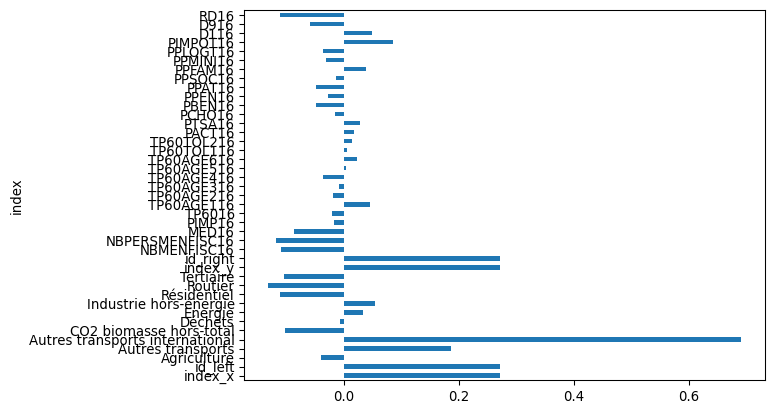

# 6. Formatting descriptive statistics tables

A `Pandas` DataFrame is automatically formatted when viewed from a notebook as a minimally styled HTML table. This formatting is convenient for viewing data, a necessary task for data scientists, but it doesn’t go much beyond that.

In an exploratory phase, it can be useful to have a more complete table, including minimal visualizations, to better understand the data. In the final phase of a project, when communicating about it, having an attractive visualization is advantageous. The outputs of notebooks are not a satisfactory solution for these needs and require the medium of the notebook, which can deter some users.

Fortunately, the young package [`great_tables`](https://posit-dev.github.io/great-tables/get-started/) allows for the creation of tables programmatically that rival tedious manual productions in `Excel` and are difficult to replicate. This package is a `Python` port of the `GT` package. `great_tables` builds *HTML* tables, offering great formatting richness and excellent integration with [`Quarto`](https://quarto.org/), the reproducible publishing tool developed by RStudio.

The following exercise will propose building a table with this package, step by step.

To focus on table construction, the necessary data preparations are provided directly. We will start from this dataset:

3 rows × 49 columns

To ensure you are able to complete the next exercise, here is the dataframe required for it.

In [72]:
emissions["emissions"] = emissions.sum(axis=1, numeric_only=True)

emissions_merged = emissions.reset_index().merge(
    filosofi, left_on="INSEE commune", right_on="CODGEO"
)
emissions_merged["empreinte"] = (
    emissions_merged["emissions"] / emissions_merged["NBPERSMENFISC16"]
)
emissions_merged["empreinte"] = emissions_merged["empreinte"].astype(float)


In [73]:
emissions_table = (
    emissions_merged.rename(
        columns={"dep_y": "dep", "NBPERSMENFISC16": "population", "MED16": "revenu"}
    )
    .groupby("dep")
    .agg(
        {"empreinte": "sum", "revenu": "median", "population": "sum"}
    )  # pas vraiment le revenu médian
    .reset_index()
    .sort_values(by="empreinte")
)


In this table, we will include horizontal bars, similar to the examples shown [here](https://posit-dev.github.io/great-tables/examples/). This is done by directly including the *HTML* code in the DataFrame column.

In [74]:
def create_bar(
    prop_fill: float, max_width: int, height: int, color: str = "green"
) -> str:
    """Create divs to represent prop_fill as a bar."""
    width = round(max_width * prop_fill, 2)
    px_width = f"{width}px"
    return f"""\
    <div style="width: {max_width}px; background-color: lightgrey;">\
        <div style="height:{height}px;width:{px_width};background-color:{color};"></div>\
    </div>\
    """


colors = {"empreinte": "green", "revenu": "red", "population": "blue"}

for variable in ["empreinte", "revenu", "population"]:
    emissions_table[f"raw_perc_{variable}"] = (
        emissions_table[variable] / emissions_table[variable].max()
    )
    emissions_table[f"bar_{variable}"] = emissions_table[f"raw_perc_{variable}"].map(
        lambda x: create_bar(x, max_width=75, height=20, color=colors[variable])
    )


We keep only the 5 smallest carbon footprints and the five largest.

In [75]:
emissions_min = (
    emissions_table.head(5)
    .assign(grp="5 départements les moins pollueurs")
    .reset_index(drop=True)
)
emissions_max = (
    emissions_table.tail(5)
    .assign(grp="5 départements les plus pollueurs")
    .reset_index(drop=True)
)

emissions_table = pd.concat([emissions_min, emissions_max])


Finally, to use some practical functions for selecting columns based on patterns, we will convert the data to the [`Polars`](https://pola.rs/) format.

In [76]:
import polars as pl

emissions_table = pl.from_pandas(emissions_table)


<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercise 5: A Beautiful Descriptive Statistics Table (Open Exercise)</h3>

Using this base table

``` python
GT(emissions_table, groupname_col="grp", rowname_col="dep")
```

construct a table in the style of the one below

</div>

Thanks to this, we can already understand that our definition of the carbon footprint is certainly flawed. It seems unlikely that the inhabitants of the 77th department have a carbon footprint 500 times greater than that of intra-muros Paris. The main reason? We are not dealing with a concept of consumption emissions but production emissions, which penalizes industrial areas or areas with airports…

To learn more about constructing tables with `great_tables`, you can replicate this [exercise](https://rgeo.linogaliana.fr/exercises/eval.html) on producing electoral tables that I proposed for an `R` course with `gt`, the equivalent of `great_tables` for `R`.

# 7. `Pandas`: towards practice and beyond

## 7.1 `Pandas` in a chain of operations

Generally, in a project, data cleaning will consist of a series of methods applied to a `DataFrame` or a `Series` when working exclusively on a single column. In other words, what is usually expected when working with `Pandas` is to have a chain that takes a `DataFrame` as input and outputs the same `DataFrame` enriched or an aggregated version of it.

This way of proceeding is at the heart of the `dplyr` syntax in `R` but is not necessarily native in `Pandas` depending on the operations you want to implement. Indeed, the natural way to update a dataframe in `Pandas` often involves syntax like:

In [79]:
import numpy as np
import pandas as pd

data = [[8000, 1000], [9500, np.nan], [5000, 2000]]
df = pd.DataFrame(data, columns=["salaire", "autre_info"])
df["salaire_net"] = df["salaire"] * 0.8


In `SQL` you could directly update your database with the new column:

``` sql
SELECT *, salaire*0.8 AS salaire_net FROM df
```

The `tidyverse` ecosystem in `R`, the equivalent of `Pandas`, works according to the same logic as SQL table updates. Indeed, you would use the following command with `dplyr`:

``` r
df %>% mutate(salaire_net = salaire*0.8) 
```

Technically, you could do this with an `assign` in `Pandas`:

In [81]:
df = df.drop("salaire_net", axis="columns")
df = df.assign(salaire_net=lambda s: s["salaire"] * 0.8)

However, this `assign` syntax is not very natural. It requires passing a lambda function that expects a `DataFrame` as input where you would want a column. So, it is not really a readable and practical syntax.

It is nevertheless possible to chain operations on datasets using [pipes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pipe.html). These follow the same philosophy as `dplyr`, itself inspired by the Linux pipe. This approach will make the code more readable by defining functions that perform operations on one or more columns of a DataFrame. The first argument to the function is the `DataFrame`, the others are those controlling its behavior:

In [82]:
def calcul_salaire_net(df: pd.DataFrame, col: str, taux: float = 0.8):
    df["salaire_net"] = df[col] * taux
    return df


This transforms our production chain into:

In [83]:
(df.pipe(calcul_salaire_net, "salaire"))


## 7.2 Some limitations regarding `Pandas` syntax

There is a before and after `Pandas` in data analysis with `Python`. Without this incredibly practical package, Python, despite all its strengths, would have struggled to establish itself in the data analysis landscape. However, while `Pandas` offers a coherent syntax in many aspects, it is not perfect either. More recent data analysis paradigms in `Python` sometimes aim to correct these syntactical imperfections.

Among the most annoying points in everyday use is the need to regularly perform `reset_index` when building descriptive statistics. Indeed, it can be dangerous to keep indices that are not well controlled because, if we are not careful during the merge phases, they can be misused by `Pandas` to join data, leading to surprises.

`Pandas` is extremely well-designed for restructuring data from long to wide format or vice versa. However, this is not the only way to restructure a dataset that we might want to implement. It often happens that we want to compare the value of an observation to that of a group to which it belongs. This is particularly useful in anomaly analysis, outlier detection, or fraud investigation. Natively, in `Pandas`, you need to build an aggregate statistic by group and then merge it back to the initial data using the group variable. This is somewhat tedious:

In [84]:
emissions_moyennes = emissions.groupby("dep").agg({"Agriculture": "mean"}).reset_index()
emissions_enrichies = emissions.merge(
    emissions_moyennes, on="dep", suffixes=["", "_moyenne_dep"]
)
emissions_enrichies["relatives"] = (
    emissions_enrichies["Agriculture"] / emissions_enrichies["Agriculture_moyenne_dep"]
)
emissions_enrichies.head()


In the `tidyverse`, this two-step operation could be done in a single step, which is more convenient:

``` r
emissions %>%
  group_by(dep) %>%
  mutate(relatives = Agriculture/mean(Agriculture))
```

This isn’t too bad, but it does make `Pandas` processing chains longer and therefore increases the maintenance burden to keep them running over time.

More generally, `Pandas` processing chains can be quite verbose because it is often necessary to redefine the `DataFrame` rather than just the columns. For example, to filter rows and columns, you have to:

In [85]:
(
    emissions.loc[
        (emissions["dep"] == "12") & (emissions["Routier"] > 500),
        ["INSEE commune", "Commune"],
    ].head(5)
)


In SQL, you could simply refer to the columns in the filter:

``` sql
SELECT "INSEE commune", 'Commune'
FROM emissions 
WHERE dep=="12" AND Routier>500
```

In the `tidyverse` (R), you could also do this simply:

``` r
df %>%
  filter(dep=="12", Routier>500) %>%
  select(`INSEE commune`, `Commune`)
```

# 8. Other paradigms

These two chapters have explored in depth the richness of the `Pandas` ecosystem, which is indispensable in the data scientist’s toolbox. Despite all the limitations we have mentioned, and the alternative solutions we will present, `Pandas` remains the central package of the data ecosystem with `Python`. In the following chapters, we will see its native integration with the `Scikit` ecosystem for machine learning or the extension of `Pandas` to spatial data with `GeoPandas`.

Other technical solutions that we will discuss here may be relevant if you want to handle large volumes of data or if you want to use alternative syntaxes.

The main alternatives to `Pandas` are [`Polars`](https://pola.rs/), [`DuckDB`](https://duckdb.org/), and [`Spark`](https://spark.apache.org/docs/latest/api/python/index.html). There is also [`Dask`](https://www.dask.org/), a library for parallelizing `Pandas` operations.

## 8.1 `Polars`

`Polars` is certainly the paradigm most inspired by `Pandas`, even in the choice of name. The first fundamental difference lies in the internal layers used. `Polars` relies on the `Rust` implementation of `Arrow`, whereas `Pandas` relies on `Numpy`, which results in performance loss. This allows `Polars` to be more efficient on large volumes of data, especially since many operations are parallelized and rely on lazy evaluation, a programming principle that optimizes queries for logical rather than defined execution order.

Another strength of `Polars` is its more coherent syntax, benefiting from over fifteen years of `Pandas` existence and almost a decade of `dplyr` (the data manipulation package within the `R` tidyverse paradigm). To take the previous example, there is no longer a need to force the reference to the DataFrame; in an execution chain, all subsequent references will be made with respect to the initial DataFrame.
²

In [87]:
import polars as pl

emissions_polars = pl.from_pandas(emissions)
(
    emissions_polars.filter(pl.col("dep") == "12", pl.col("Routier") > 500)
    .select("INSEE commune", "Commune")
    .head(5)
)


To learn about `Polars`, many online resources are available, including [this notebook](https://github.com/InseeFrLab/ssphub/blob/main/post/polars/polars-tuto.ipynb) built for the public statistics data scientists network.

## 8.2 `DuckDB`

`DuckDB` is the newcomer in the data analysis ecosystem, pushing the limits of data processing with `Python` without resorting to big data tools like `Spark`. `DuckDB` epitomizes a new paradigm, the [“Big data is dead”](https://motherduck.com/blog/big-data-is-dead/) paradigm, where large data volumes can be processed without imposing infrastructures.

Besides its great efficiency, as `DuckDB` can handle data volumes larger than the computer or server’s RAM, it offers the advantage of a uniform syntax across languages that call `DuckDB` (`Python`, `R`, `C++`, or `Javascript`). `DuckDB` favors SQL syntax for data processing with many pre-implemented functions to simplify certain data transformations (e.g., for [text data](https://duckdb.org/docs/sql/functions/char.html), [time data](https://duckdb.org/docs/sql/functions/time), etc.).

Compared to other SQL-based systems like [`PostGreSQL`](https://www.postgresql.org/), `DuckDB` is very simple to install, as it is just a `Python` library, whereas many tools like `PostGreSQL` require an appropriate infrastructure.

To reuse the previous example, we can directly use the SQL code mentioned earlier.

In [89]:
import duckdb

duckdb.sql(
    """
  SELECT "INSEE commune", "Commune"
  FROM emissions
  WHERE dep=='12' AND Routier>500
  LIMIT 5
  """
)


┌───────────────┬─────────────────────┐
│ INSEE commune │       Commune       │
│    varchar    │       varchar       │
├───────────────┼─────────────────────┤
│ 12001         │ AGEN-D'AVEYRON      │
│ 12002         │ AGUESSAC            │
│ 12006         │ ALRANCE             │
│ 12007         │ AMBEYRAC            │
│ 12008         │ ANGLARS-SAINT-FELIX │
└───────────────┴─────────────────────┘

Here, the clause `FROM emissions` comes from the fact that we can directly execute SQL from a `Pandas` object via `DuckDB`. If we read directly in the query, it gets slightly more complex, but the logic remains the same.

In [90]:
import duckdb

duckdb.sql(
    f"""
  SELECT "INSEE commune", "Commune"
  FROM read_csv_auto("{url}")
  WHERE
    substring("INSEE commune",1,2)=='12'
    AND
    Routier>500
  LIMIT 5
  """
)


┌───────────────┬─────────────────────┐
│ INSEE commune │       Commune       │
│    varchar    │       varchar       │
├───────────────┼─────────────────────┤
│ 12001         │ AGEN-D'AVEYRON      │
│ 12002         │ AGUESSAC            │
│ 12006         │ ALRANCE             │
│ 12007         │ AMBEYRAC            │
│ 12008         │ ANGLARS-SAINT-FELIX │
└───────────────┴─────────────────────┘

The rendering of the DataFrame is slightly different from `Pandas` because, like `Polars` and many large data processing systems, `DuckDB` relies on lazy evaluation and thus only displays a sample of data. `DuckDB` and `Polars` are also well integrated with each other. You can run SQL on a `Polars` object via `DuckDB` or apply `Polars` functions to an initially read `DuckDB` object.

One of the interests of `DuckDB` is its excellent integration with the `Parquet` ecosystem, the already mentioned data format that is becoming a standard in data sharing (for example, it is the cornerstone of data sharing on the HuggingFace platform). To learn more about `DuckDB` and discover its usefulness for reading data from the French population census, you can check out [this blog post](https://ssphub.netlify.app/post/parquetrp/).

## 8.3 `Spark`

`DuckDB` has pushed the boundaries of big data, which can be defined as the volume of data that can no longer be processed on a single machine without implementing a parallelization strategy.

Nevertheless, for very large data volumes, `Python` is well-equipped with the [`PySpark`](https://spark.apache.org/docs/latest/api/python/index.html) library. This is a Python API for the Spark language, a big data language based on Scala. This paradigm is built on the idea that `Python` users access it via clusters with many nodes to process data in parallel. The data will be read in blocks, processed in parallel depending on the number of parallel nodes. The `Spark` DataFrame API has a syntax close to previous paradigms with more complex engineering in the background related to native parallelization.